Neuromorphic engineering I

## Lab 8: Silicon Synaptic Circuits

Team member 1: Quillan Favey

Team member 2: Hooman Javaheri

Date: 21.11.22

----------------------------------------------------------------------------------------------------------------------

This week, we will see how synaptic circuits generate currents when stimulated by voltage pulses. Specifically we will measure the response of the synapse to a single pulse, and to a sequence of spikes.

The objectives of this lab are to:
- Analyze log-domain synapse circuits.
- Measure the response properties of the diff-pair integrator (DPI) synapse and of the dual diff-pair integrator (DDI) synapse.


## 1. Prelab

**A Differential Pair Integrator circuit**

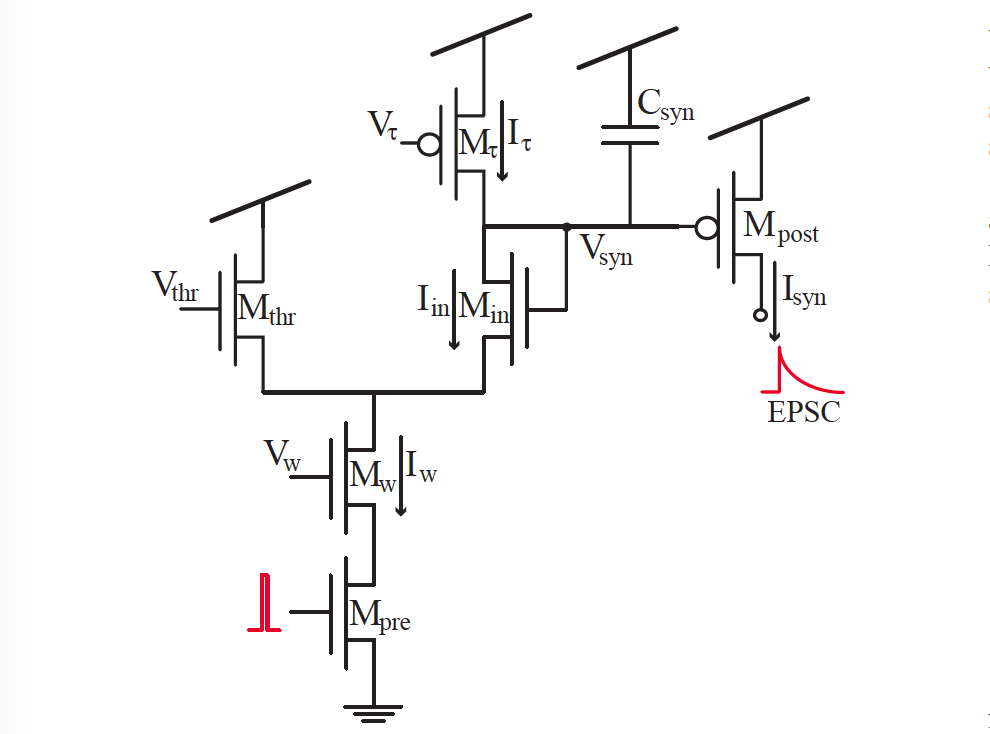

**(1)** Write the equations characterizing $I_{w}, I_{thr} , I_{in}, I_{\tau}, I_{syn}, I_C$ assuming all corresponding FETs are in saturation and operate in weak-inversion.

$$
I_{w} =  I_0e^\frac{\kappa V_W}{U_T} \\
I_{thr} = I_0e^\frac{\kappa V_{Thr}-V_{dd00}}{U_T} \\
I_{in} = I_W \frac{e^frac{\kappa V_{syn}}{U_T}}{e^\frac{\kappa V_{syn}}{U_T}+e^\frac{\kappa V_{Thr}}{U_T}} \\
I_{\tau} = I_0e^\frac{\kappa (V_{dd}-V_{\tau})}{U_T} \\
I_{syn} = I_0e^\frac{\kappa (V_{dd}-V_{syn})}{U_T} \\
I_C = C\frac{d}{dt}(V_{dd}-V_{syn}) \\
$$

**(2)** What is the time constant of the circuit?

$\tau = \frac{C_{syn} U_T}{\kappa I_{\tau}}$

**(3)** Derive the circuit's response to a step input assuming $I_{w}(t < 0) = 0, I_{w}(t > 0) \gg I_{\tau}$.

The non-linear ODE for this circuit is:

$$
\tau(1+\frac{I_{th}}{I_{syn}})\frac{d}{dt}I_{syn}+I_{syn} = \frac{I_{th}I_{in}}{I_{\tau}}-I_{th}
$$

If $I_{syn}$ increases enough (such as $I_{syn}>I_{Th}$) and $I_W >> I_{\tau}$ we get the following diff equation:

$$
\tau\frac{d}{dt}I_{syn}+I_{syn} = \frac{I_{th}I_{in}}{I_{\tau}} = \frac{I_{w}I_{gain}}{I_{\tau}}
$$

and so:

$$
\frac{d}{dt}I_{syn} = \frac{I_{w}I_{gain}}{I_{\tau}\tau}-\frac{I_{syn}}{\tau}
$$

By solving (Laplace-Heaviside), taking $I_w=X=\text{input, and } Y=I_{syn}$ we get:
$$
H(s) = \frac{Y}{X}=\frac{I_g}{I_{\tau}(1+\tau s)}
$$
We can then find the poles:
$$
s = -\frac{1}{\tau}
$$
We can then replace in the general form of the solution:
$$
y(t) = Y e^-\frac{t}{\tau}
$$
Then use the $H(s)$ equation to solve for $Y$:
$$
Y = \frac{I_g X}{I_{\tau}(1+\tau s)}
$$
We can then replace the terms into the differential equation and add the particular solution (or initial condition), and we get:
$$
I_{syn}(t)=
\frac{I_{gain} I_{w}}{I_\tau}\left(1-e^{-\frac{\left(t-t_i^{-}\right)}{\tau}}\right)+I_{syn}^{-} e^{-\frac{\left(t-t_i^{-}\right)}{\tau}} \\
$$

where, $t_i^{+}-t_i^{-}$ is the duration of the input spike and $I_{syn}^{-}$ is the initial current at $t=0$

**(4)** Derive the circuit's response to a step input assuming $I_{w}(t < 0) \gg I_{\tau}, I_{w}(t > 0) = 0$.


We proceed the same way as previously and we get:
$$
I_{syn}(t)=\left\{\begin{array}{l}
I_{s y n}^{+} e^{-\frac{\left(t-t_i^{+}\right)}{\tau}}
\end{array}\right.
$$


**(5)** Suppose we stimulate the circuit with a regular spike train of frequency $f$ (high enough). What happens to $I_{syn}$ in steady-state (average value)? 

At steady state, we have:

$$
\frac{d}{dt}I_{syn} = \frac{I_{w}I_{gain}}{I_{\tau}}-I_{syn} = 0
$$

So

$$
<I_{syn}>= \frac{I_{w}I_{gain}}{I_{\tau}}f \Delta t
$$


Where $\Delta t$ is the pulse duration. $I_{Syn}$ is linearly dependant on the spike frequency

**(6)** In what conditions (tau and thr) is the step response dependent only on $I_{w}$?


If $I_{gain/thr}=I_{\tau}$ and then $I_{syn}$ is entirely dependent on $I_w$. We can also view this by plotting the charge equation (the first diff. equation). The equation plateaus at $I_w$. In the other case it would plateau at $\frac{I_w I_{gain}}{I_{\tau}}$

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_charge(dt=20,Iw = 1, Ig = 1, It = 1, tau = 3):
    t = np.arange(0,dt)
    Isynt = [((Ig*Iw)/It)*(1-np.exp(-(i/tau))) for i in t]
    return Isynt, t

I1, t1 = plot_charge()
I2, t2 = plot_charge(Iw = 2)
plt.plot(t1,I1,label=r"$I_w = 1$")
plt.plot(t2,I2,label=r"$I_w = 2$")
plt.legend()
plt.title(r"Comparison of $I_{syn}(t)=\frac{I_{gain} I_{w}}{I_\tau}\left(1-e^{-\frac{\left(t-t_i^{-}\right)}{\tau}}\right)+I_{syn}^{-} e^{-\frac{\left(t-t_i^{-}\right)}{\tau}}$ for different Iw")

# 2 Setup

## 2.1 Connect the device

In [ ]:
# import the necessary libraries
import pyplane
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [ ]:
# create a Plane object and open the communication
if 'p' not in locals():
    p = pyplane.Plane()
    try:
        p.open('/dev/ttyACM0')
    except RuntimeError as e:
        del p
        print(e)

In [ ]:
p.get_firmware_version()

In [ ]:
# Send a reset signal to the board, check if the LED blinks
p.reset(pyplane.ResetType.Soft)
time.sleep(0.5) 
# NOTE: You must send this request events every time you do a reset operetion, otherwise the recieved data is noisy.
# Because the class chip need to do handshake to get the communication correct.
p.request_events(1)

In [ ]:
# Try to read something, make sure the chip responses
p.read_current(pyplane.AdcChannel.GO0_N)

In [ ]:
 # If any of the above steps fail, delete the object, close and halt, stop the server and ask the TA to restart
# please also say your board number: ttyACMx
# del p

## 2.2 Chip configuration

* To measure DPI synapse:

In [ ]:
p.send_coach_events([pyplane.Coach.generate_aerc_event(
    pyplane.pyplane.Coach.CurrentOutputSelect.SelectLine5,
    pyplane.Coach.VoltageOutputSelect.SelectLine2,
    pyplane.Coach.VoltageInputSelect.NoneSelected,
    pyplane.Coach.SynapseSelect.DPI,0)])

## 2.3 C2F

* To set up the C2F circuit:

In [ ]:
# setup C2F
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.C2F_HYS_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 100)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.C2F_BIAS_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 255)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.C2F_PWLK_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 255)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.C2F_REF_L, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 255)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.C2F_REF_H, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 255)])

# setup output rail-to-rail buffer
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.RR_BIAS_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 255)])

## 2.4 BiasGen

In a simplified form, the output of a branch of the BiasGen will be the gate voltage $V_b$ for the bias current $I_b$, and if the current mirror has a ratio of $w$ and the bias transistor operates in subthreshold-saturation:
\begin{equation}
I_b = w\frac{BG_{fine}}{256}I_{BG_{master}}
\end{equation}
Where $I_{BG_{master}}$ is the `BiasGenMasterCurrent` $\in \left\{ 60~\rm{pA}, 460~\rm{pA}, 3.8~\rm{nA}, 30~\rm{nA}, 240~\rm{nA} \right\}$, $BG_{fine}$ is the integer fine value $\in [0, 256)$

To set a bias, use the function similar to the following:

```
p.send_coach_event(pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.BIAS_NAME, \
    pyplane.Coach.BiasType.BIAS_TYPE, \
    pyplane.Coach.BiasGenMasterCurrent.MASTER_CURRENT, FINE_VALUE))
```

**You may have noticed that there are some biases that are not used to directly generate a current, but rather what matters is the voltage, e.g. $V_{gain}$, $V_{ex}$ and $V_{inh}$ in our HWTA circuit. Even though they may have a `BIAS_NAME` ending with `_N` or `_P` it only indicates that they are connected to the gate of an N- or a P-FET, but the `BIAS_TYPE` parameter can be both `_N` or `_P`. For example, setting a `_N` bias to `BIAS_TYPE = P` will only make this voltage very close to GND, which _is_ sometimes the designed use case.**

## 2.5 Pulse extender circuit

In case you didn't look into the last problem in prelab, the pulse extender circuit basically defines the pulse width, which is inversely proportional to the parameter `PEX_VTAU_N`.

# 3 DPI synapse

The **DPI synapse** receives a voltage pulse train, $V_{pulse}$, as input and
outputs a corresponding synaptic current, $I_{syn}$. Additionally, the synaptic voltage, $V_{syn}$, is provided.
Bias parameters $V_{weight}$ & $V_{tau}$ affect the amplitude and decay of the response, while $V_{thr}$ acts as an additional weight bias. $C_{syn}$ sizing was chosen for a capacitance of 2pF. 

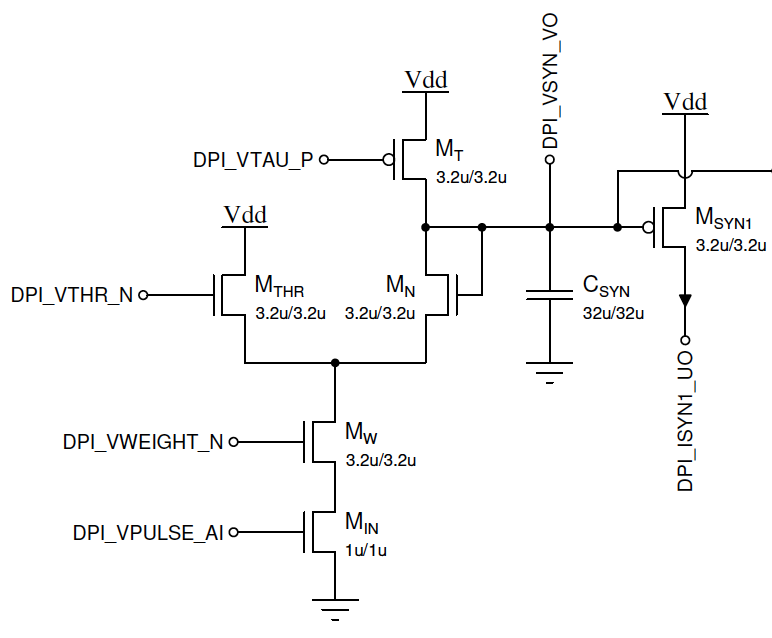

**Pin map**

**$V_{syn}$ = adc[14]**

**$I_{syn}$ = c2f[9]**

The task of this exercise it to tune the parameters and observe the behavior of the DPI synapse.

## 3.1 Basic impulse response

- **Set parameters**

In [ ]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTAU_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 25)])    

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTHR_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 30)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VWEIGHT_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 100)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PEX_VTAU_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 10)])

- **Data acquisition**

In [ ]:
N_pulses = 2 # for each trial, send 2 input pulses
N_samples_per_pulse = 10 # for each input pulse, sample 10 points
N_samples = N_pulses*N_samples_per_pulse
dT = 0.02 # delta t between the samples, DO NOT CHANGE
t = np.arange(N_samples)*dT
vsyn = np.zeros(N_samples)
isyn = np.zeros(N_samples)
for k in range(N_pulses):
    p.send_coach_events([pyplane.Coach.generate_pulse_event()])
    for i in range(N_samples_per_pulse):
        vsyn[k*N_samples_per_pulse+i] += p.read_voltage(pyplane.AdcChannel.AOUT14)
        inter=p.read_c2f_output(dT)
        isyn[k*N_samples_per_pulse+i] += inter[9]




- **Plot the data**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 15})

t,vsyn,isyn = np.loadtxt('data_ex_3_1.csv',delimiter=',')
plt.plot(t,vsyn,'-')

plt.xlabel('t [s]')
plt.ylabel('$V_{syn}$ [V]')
plt.legend(['$V_{syn}$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 1: Measured values of $V_{syn}$ as a function of time')

plt.grid()
plt.show()

plt.plot(t,isyn,'-')

plt.xlabel('t [s]')
plt.ylabel('C2F [Hz]')
plt.legend(['C2F$(I_{syn})$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 2: Measured C2F values of $I_{syn}$ as a function of time')

plt.grid()
plt.show()

- **Save the data**

In [ ]:
np.savetxt('data_ex_3_1.csv',[t,vsyn,isyn] , delimiter=',')

## 3.2 Different $I_{weight}$

Repeat 3.1 with a smaller and a larger  $I_{weight}$, compare the three curves in the same plot.

- **Set smaller bias**

In [ ]:
## REMINDER , RESET ALL PARAMETERS AS 3.1 
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTAU_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 25)])    

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTHR_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 30)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VWEIGHT_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 50)]) #change weight

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PEX_VTAU_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 10)])

- **Data acquisition**

In [ ]:
N_pulses = 2 # for each trial, send 2 input pulses
N_samples_per_pulse = 10 # for each input pulse, sample 10 points
N_samples = N_pulses*N_samples_per_pulse
dT = 0.02 # delta t between the samples, DO NOT CHANGE
t = np.arange(N_samples)*dT
vsyn = np.zeros(N_samples)
isyn = np.zeros(N_samples)
for k in range(N_pulses):
    p.send_coach_events([pyplane.Coach.generate_pulse_event()])
    for i in range(N_samples_per_pulse):
        vsyn[k*N_samples_per_pulse+i] += p.read_voltage(pyplane.AdcChannel.AOUT14)
        inter=p.read_c2f_output(dT)
        isyn[k*N_samples_per_pulse+i] += inter[9]

- **Save data**

In [ ]:
np.savetxt('data_ex_3_2_smaller.csv',[t,vsyn,isyn] , delimiter=',')

- **Set largerer bias**

In [ ]:
#Insert a bigger I weight
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTAU_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 25)])    

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTHR_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 30)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VWEIGHT_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 35)]) #change weight

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PEX_VTAU_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 10)])

- **Data acquisition**

In [ ]:
N_pulses = 2 # for each trial, send 2 input pulses
N_samples_per_pulse = 10 # for each input pulse, sample 10 points
N_samples = N_pulses*N_samples_per_pulse
dT = 0.02 # delta t between the samples, DO NOT CHANGE
t = np.arange(N_samples)*dT
vsyn = np.zeros(N_samples)
isyn = np.zeros(N_samples)
for k in range(N_pulses):
    p.send_coach_events([pyplane.Coach.generate_pulse_event()])
    for i in range(N_samples_per_pulse):
        vsyn[k*N_samples_per_pulse+i] += p.read_voltage(pyplane.AdcChannel.AOUT14)
        inter=p.read_c2f_output(dT)
        isyn[k*N_samples_per_pulse+i] += inter[9]

- **Save data**

In [ ]:
np.savetxt('data_ex_3_2_bigger.csv',[t,vsyn,isyn] , delimiter=',')

- **Plot**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 15})


t,vsyn_smaller,isyn_smaller = np.loadtxt('data_ex_3_2_smaller.csv',delimiter=',')
_,vsyn_normal,isyn_normal = np.loadtxt('data_ex_3_1.csv',delimiter=',')
_,vsyn_bigger,isyn_bigger = np.loadtxt('data_ex_3_2_bigger.csv',delimiter=',')

plt.plot(t,vsyn_smaller,t,vsyn_normal,t,vsyn_bigger)

plt.xlabel('t [s]')
plt.ylabel('$V_{syn}$ [V]')
plt.legend(['$V_{syn}$ - Smaller $I_w$','$V_{syn}$ - Normal $I_w$','$V_{syn}$ - Larger $I_w$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 3: Measured values of $V_{syn}$ as function of time for varying $I_{w}$')

plt.grid()
plt.show()

plt.plot(t[1:],isyn_smaller[1:],t,isyn_normal,t,isyn_bigger)

plt.xlabel('t [s]')
plt.ylabel('C2F [Hz]')
plt.legend(['C2F$(I_{syn})$ - Smaller $I_w$','C2F$(I_{syn})$ - Normal $I_w$','C2F$(I_{syn})$ - Larger $I_w$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 4: Measured values of $I_{syn}$ as function of time for varying $I_{w}$')

plt.grid()
plt.show()

## 3.3 Different $I_{tau}$

Repeat 3.1 with a smaller and a larger  $I_{tau}$, compare the three curves in the same plot.

In [ ]:
## REMINDER , RESET ALL PARAMETERS AS 3.1 
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTAU_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 5)])   #change tau 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTHR_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 30)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VWEIGHT_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 100)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PEX_VTAU_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 10)])

In [ ]:
N_pulses = 2 # for each trial, send 2 input pulses
N_samples_per_pulse = 10 # for each input pulse, sample 10 points
N_samples = N_pulses*N_samples_per_pulse
dT = 0.02 # delta t between the samples, DO NOT CHANGE
t = np.arange(N_samples)*dT
vsyn = np.zeros(N_samples)
isyn = np.zeros(N_samples)
for k in range(N_pulses):
    p.send_coach_events([pyplane.Coach.generate_pulse_event()])
    for i in range(N_samples_per_pulse):
        vsyn[k*N_samples_per_pulse+i] += p.read_voltage(pyplane.AdcChannel.AOUT14)
        inter=p.read_c2f_output(dT)
        isyn[k*N_samples_per_pulse+i] += inter[9]

In [ ]:
np.savetxt('data_ex_3_3_smaller.csv',[t,vsyn,isyn] , delimiter=',')

In [ ]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTAU_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 50)])    #change tau

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTHR_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 30)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VWEIGHT_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 100)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PEX_VTAU_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 10)])

In [ ]:
N_pulses = 2 # for each trial, send 2 input pulses
N_samples_per_pulse = 10 # for each input pulse, sample 10 points
N_samples = N_pulses*N_samples_per_pulse
dT = 0.02 # delta t between the samples, DO NOT CHANGE
t = np.arange(N_samples)*dT
vsyn = np.zeros(N_samples)
isyn = np.zeros(N_samples)
for k in range(N_pulses):
    p.send_coach_events([pyplane.Coach.generate_pulse_event()])
    for i in range(N_samples_per_pulse):
        vsyn[k*N_samples_per_pulse+i] += p.read_voltage(pyplane.AdcChannel.AOUT14)
        inter=p.read_c2f_output(dT)
        isyn[k*N_samples_per_pulse+i] += inter[9]

In [ ]:
np.savetxt('data_ex_3_3_bigger.csv',[t,vsyn,isyn] , delimiter=',')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 15})


t,vsyn_smaller,isyn_smaller = np.loadtxt('data_ex_3_3_smaller.csv',delimiter=',')
_,vsyn_normal,isyn_normal = np.loadtxt('data_ex_3_1.csv',delimiter=',')
_,vsyn_bigger,isyn_bigger = np.loadtxt('data_ex_3_3_bigger.csv',delimiter=',')

plt.plot(t,vsyn_smaller,t,vsyn_normal,t,vsyn_bigger)

plt.xlabel('t [s]')
plt.ylabel('$V_{syn}$ [V]')
plt.legend(['$V_{syn}$ - Smaller $I_{𝜏}$','$V_{syn}$ - Normal $I_{𝜏}$','$V_{syn}$ - Larger $I_{𝜏}$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 5: Measured values of $V_{syn}$ as function of time for varying $I_{𝜏}$')

plt.grid()
plt.show()

plt.plot(t,isyn_smaller,t,isyn_normal,t,isyn_bigger)

plt.xlabel('t [s]')
plt.ylabel('C2F [Hz]')
plt.legend(['C2F$(I_{syn})$ - Smaller $I_{𝜏}$','C2F$(I_{syn})$ - Normal $I_{𝜏}$','C2F$(I_{syn})$ - Larger $I_{𝜏}$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 6: Measured values of $I_{syn}$ as function of time for varying $I_{𝜏}$')

plt.grid()
plt.show()

## 3.4 Different $I_{thr}$

Repeat 3.1 with a smaller and a larger $I_{thr}$, compare the three curves in the same plot.

In [ ]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTAU_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 25)])    

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTHR_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 10)]) #change threshold 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VWEIGHT_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 100)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PEX_VTAU_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 10)])

In [ ]:
N_pulses = 2 # for each trial, send 2 input pulses
N_samples_per_pulse = 10 # for each input pulse, sample 10 points
N_samples = N_pulses*N_samples_per_pulse
dT = 0.02 # delta t between the samples, DO NOT CHANGE
t = np.arange(N_samples)*dT
vsyn = np.zeros(N_samples)
isyn = np.zeros(N_samples)
for k in range(N_pulses):
    p.send_coach_events([pyplane.Coach.generate_pulse_event()])
    for i in range(N_samples_per_pulse):
        vsyn[k*N_samples_per_pulse+i] += p.read_voltage(pyplane.AdcChannel.AOUT14)
        inter=p.read_c2f_output(dT)
        isyn[k*N_samples_per_pulse+i] += inter[9]

In [ ]:
np.savetxt('data_ex_3_4_smaller.csv',[t,vsyn,isyn] , delimiter=',')

In [ ]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTAU_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 25)])    

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTHR_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 80)]) #change threshold 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VWEIGHT_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 100)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PEX_VTAU_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 10)]) 

In [ ]:
N_pulses = 2 # for each trial, send 2 input pulses
N_samples_per_pulse = 10 # for each input pulse, sample 10 points
N_samples = N_pulses*N_samples_per_pulse
dT = 0.02 # delta t between the samples, DO NOT CHANGE
t = np.arange(N_samples)*dT
vsyn = np.zeros(N_samples)
isyn = np.zeros(N_samples)
for k in range(N_pulses):
    p.send_coach_events([pyplane.Coach.generate_pulse_event()])
    for i in range(N_samples_per_pulse):
        vsyn[k*N_samples_per_pulse+i] += p.read_voltage(pyplane.AdcChannel.AOUT14)
        inter=p.read_c2f_output(dT)
        isyn[k*N_samples_per_pulse+i] += inter[9]

In [ ]:
np.savetxt('data_ex_3_4_bigger.csv',[t,vsyn,isyn] , delimiter=',')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 15})


t,vsyn_smaller,isyn_smaller = np.loadtxt('data_ex_3_4_smaller.csv',delimiter=',')
_,vsyn_normal,isyn_normal = np.loadtxt('data_ex_3_1.csv',delimiter=',')
_,vsyn_bigger,isyn_bigger = np.loadtxt('data_ex_3_4_bigger.csv',delimiter=',')

plt.plot(t,vsyn_smaller,t,vsyn_normal,t,vsyn_bigger)

plt.xlabel('t [s]')
plt.ylabel('$V_{syn}$ [V]')
plt.legend(['$V_{syn}$ - Smaller $I_{thr}$','$V_{syn}$ - Normal $I_{thr}$','$V_{syn}$ - Larger $I_{thr}$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 7: Measured values of $V_{syn}$ as function of time for varying $I_{thr}$')

plt.grid()
plt.show()

plt.plot(t[1:],isyn_smaller[1:],t,isyn_normal,t,isyn_bigger)

plt.xlabel('t [s]')
plt.ylabel('C2F [Hz]')
plt.legend(['C2F$(I_{syn})$ - Smaller $I_{thr}$','C2F$(I_{syn})$ - Normal $I_{thr}$','C2F$(I_{syn})$ - Larger $I_{thr}$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 8: Measured values of $I_{syn}$ as function of time for varying $I_{thr}$')

plt.grid()
plt.show()

## 3.5 Different pulse width

Repeat 3.1 with a smaller and a larger pulse width, compare the three curves in the same plot.

smaller width

In [ ]:
## 3.1 Basic impulse response

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTAU_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 25)])    

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTHR_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 30)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VWEIGHT_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 20)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PEX_VTAU_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 10)])

N_pulses = 2 # for each trial, send 2 input pulses
N_samples_per_pulse = 10 # for each input pulse, sample 10 points
N_samples = N_pulses*N_samples_per_pulse
dT = 0.02 # delta t between the samples, DO NOT CHANGE
t = np.arange(N_samples)*dT
vsyn = np.zeros(N_samples)
isyn = np.zeros(N_samples)
for k in range(N_pulses):
    p.send_coach_events([pyplane.Coach.generate_pulse_event()])
    for i in range(N_samples_per_pulse):
        vsyn[k*N_samples_per_pulse+i] += p.read_voltage(pyplane.AdcChannel.AOUT14)
        inter=p.read_c2f_output(dT)
        isyn[k*N_samples_per_pulse+i] += inter[9]



import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 15})

np.savetxt('data_ex_3_5_20.csv',[t,vsyn,isyn] , delimiter=',')
t,vsyn,isyn = np.loadtxt('data_ex_3_5_20.csv',delimiter=',')

plt.plot(t,vsyn,'-')

plt.xlabel('t [s]')
plt.ylabel('$V_{syn}$ [V]')
plt.legend(['$V_{syn}$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 1: Measured values of $V_{syn}$ as a function of time')

plt.grid()
plt.show()

plt.plot(t,isyn,'-')

plt.xlabel('t [s]')
plt.ylabel('C2F [Hz]')
plt.legend(['C2F$(I_{syn})$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 2: Measured C2F values of $I_{syn}$ as a function of time')

plt.grid()
plt.show()



avg width

In [ ]:
## 3.1 Basic impulse response

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTAU_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 25)])    

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTHR_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 30)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VWEIGHT_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 100)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PEX_VTAU_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 10)])

N_pulses = 2 # for each trial, send 2 input pulses
N_samples_per_pulse = 10 # for each input pulse, sample 10 points
N_samples = N_pulses*N_samples_per_pulse
dT = 0.02 # delta t between the samples, DO NOT CHANGE
t = np.arange(N_samples)*dT
vsyn = np.zeros(N_samples)
isyn = np.zeros(N_samples)
for k in range(N_pulses):
    p.send_coach_events([pyplane.Coach.generate_pulse_event()])
    for i in range(N_samples_per_pulse):
        vsyn[k*N_samples_per_pulse+i] += p.read_voltage(pyplane.AdcChannel.AOUT14)
        inter=p.read_c2f_output(dT)
        isyn[k*N_samples_per_pulse+i] += inter[9]



import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 15})

np.savetxt('data_ex_3_5_100.csv',[t,vsyn,isyn] , delimiter=',')
t,vsyn,isyn = np.loadtxt('data_ex_3_5_100.csv',delimiter=',')
plt.plot(t,vsyn,'-')

plt.xlabel('t [s]')
plt.ylabel('$V_{syn}$ [V]')
plt.legend(['$V_{syn}$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 1: Measured values of $V_{syn}$ as a function of time')

plt.grid()
plt.show()

plt.plot(t,isyn,'-')

plt.xlabel('t [s]')
plt.ylabel('C2F [Hz]')
plt.legend(['C2F$(I_{syn})$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 2: Measured C2F values of $I_{syn}$ as a function of time')

plt.grid()
plt.show()


In [ ]:
## 3.1 Basic impulse response

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTAU_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 25)])    

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTHR_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 30)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VWEIGHT_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 100)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PEX_VTAU_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 10)])

N_pulses = 2 # for each trial, send 2 input pulses
N_samples_per_pulse = 10 # for each input pulse, sample 10 points
N_samples = N_pulses*N_samples_per_pulse
dT = 0.02 # delta t between the samples, DO NOT CHANGE
t = np.arange(N_samples)*dT
vsyn = np.zeros(N_samples)
isyn = np.zeros(N_samples)
for k in range(N_pulses):
    p.send_coach_events([pyplane.Coach.generate_pulse_event()])
    for i in range(N_samples_per_pulse):
        vsyn[k*N_samples_per_pulse+i] += p.read_voltage(pyplane.AdcChannel.AOUT14)
        inter=p.read_c2f_output(dT)
        isyn[k*N_samples_per_pulse+i] += inter[9]



import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 15})
np.savetxt('data_ex_3_5_100.csv',[t,vsyn,isyn] , delimiter=',')
t,vsyn,isyn = np.loadtxt('data_ex_3_5_100.csv',delimiter=',')
plt.plot(t,vsyn,'-')

plt.xlabel('t [s]')
plt.ylabel('$V_{syn}$ [V]')
plt.legend(['$V_{syn}$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 1: Measured values of $V_{syn}$ as a function of time')

plt.grid()
plt.show()

plt.plot(t,isyn,'-')

plt.xlabel('t [s]')
plt.ylabel('C2F [Hz]')
plt.legend(['C2F$(I_{syn})$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 2: Measured C2F values of $I_{syn}$ as a function of time')

plt.grid()
plt.show()



In [ ]:
## 3.1 Basic impulse response

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTAU_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 25)])    

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTHR_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 30)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VWEIGHT_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 200)]) 

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PEX_VTAU_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 10)])

N_pulses = 2 # for each trial, send 2 input pulses
N_samples_per_pulse = 10 # for each input pulse, sample 10 points
N_samples = N_pulses*N_samples_per_pulse
dT = 0.02 # delta t between the samples, DO NOT CHANGE
t = np.arange(N_samples)*dT
vsyn = np.zeros(N_samples)
isyn = np.zeros(N_samples)
for k in range(N_pulses):
    p.send_coach_events([pyplane.Coach.generate_pulse_event()])
    for i in range(N_samples_per_pulse):
        vsyn[k*N_samples_per_pulse+i] += p.read_voltage(pyplane.AdcChannel.AOUT14)
        inter=p.read_c2f_output(dT)
        isyn[k*N_samples_per_pulse+i] += inter[9]



import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 15})
np.savetxt('data_ex_3_5_200.csv',[t,vsyn,isyn] , delimiter=',')
t,vsyn,isyn = np.loadtxt('data_ex_3_5_200.csv',delimiter=',')

plt.plot(t,vsyn,'-')

plt.xlabel('t [s]')
plt.ylabel('$V_{syn}$ [V]')
plt.legend(['$V_{syn}$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 1: Measured values of $V_{syn}$ as a function of time')

plt.grid()
plt.show()

plt.plot(t,isyn,'-')

plt.xlabel('t [s]')
plt.ylabel('C2F [Hz]')
plt.legend(['C2F$(I_{syn})$'],bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 2: Measured C2F values of $I_{syn}$ as a function of time')

plt.grid()
plt.show()



In [ ]:
t,vsyn,isyn = np.loadtxt('data_ex_3_5_200.csv',delimiter=',')
t1,vsyn1,isyn1 = np.loadtxt('data_ex_3_5_20.csv',delimiter=',')
t2,vsyn2,isyn2 = np.loadtxt('data_ex_3_5_100.csv',delimiter=',')


plt.plot(t,vsyn,'-',label='$Larger$')
plt.plot(t1,vsyn1,'-',label='$Lower$')
plt.plot(t2,vsyn2,'-',label='$Medium$')

plt.xlabel('t [s]')
plt.ylabel('$V_{syn}$ [V]')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 1: Measured values of $V_{syn}$ as a function of time')

plt.grid()
plt.show()

plt.plot(t,isyn,'-',label='$Larger$')
plt.plot(t1,isyn1,'-',label='$Lower$')
plt.plot(t2,isyn2,'-',label='$Medium$')

plt.xlabel('t [s]')
plt.ylabel('C2F [Hz]')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left') 
plt.title('Fig. 2: Measured C2F values of $I_{syn}$ as a function of time')

plt.grid()